### Imports

In [9]:
import perceval as pcvl
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from perceval.algorithm import Sampler
from tqdm import tqdm
from perceval.components.unitary_components import PS, BS, PERM

# Use the symbolic skin for display
from perceval.rendering.circuit import DisplayConfig, SymbSkin
from perceval.rendering.format import Format
DisplayConfig.select_skin(SymbSkin)

# Imports for the fitting
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

### Set the plot parameters to make us look good in the presentation

In [10]:
FIGURE_WIDTH_1COL = 3.404  # For PRX style, change for according to journal
FIGURE_WIDTH_2COL = 7.057  # For PRX style, change for according to journal
FIGURE_HEIGHT_1COL_GR = FIGURE_WIDTH_1COL*2/(1 + np.sqrt(5))
FIGURE_HEIGHT_2COL_GR = FIGURE_WIDTH_2COL*2/(1 + np.sqrt(5))

font_size = 6 # For PRX style, change for according to journal

plt.rcParams.update({
    'font.size'           : font_size,  
    'figure.titlesize'    : 'medium',
    'figure.dpi'          : 1000,
    'figure.figsize'      : (FIGURE_WIDTH_1COL, FIGURE_HEIGHT_1COL_GR),
    'axes.titlesize'      : 'medium',
    'axes.axisbelow'      : True,
    'xtick.direction'     : 'in',
    'xtick.labelsize'     : 'small',
    'ytick.direction'     : 'in',
    'ytick.labelsize'     : 'small',
    'image.interpolation' : 'none',
    'legend.fontsize': font_size,
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
})


plt.rcParams.update({'font.family':'sans-serif'})

### Load our data

We use tidal data on the Irish Coast in Dublin. 

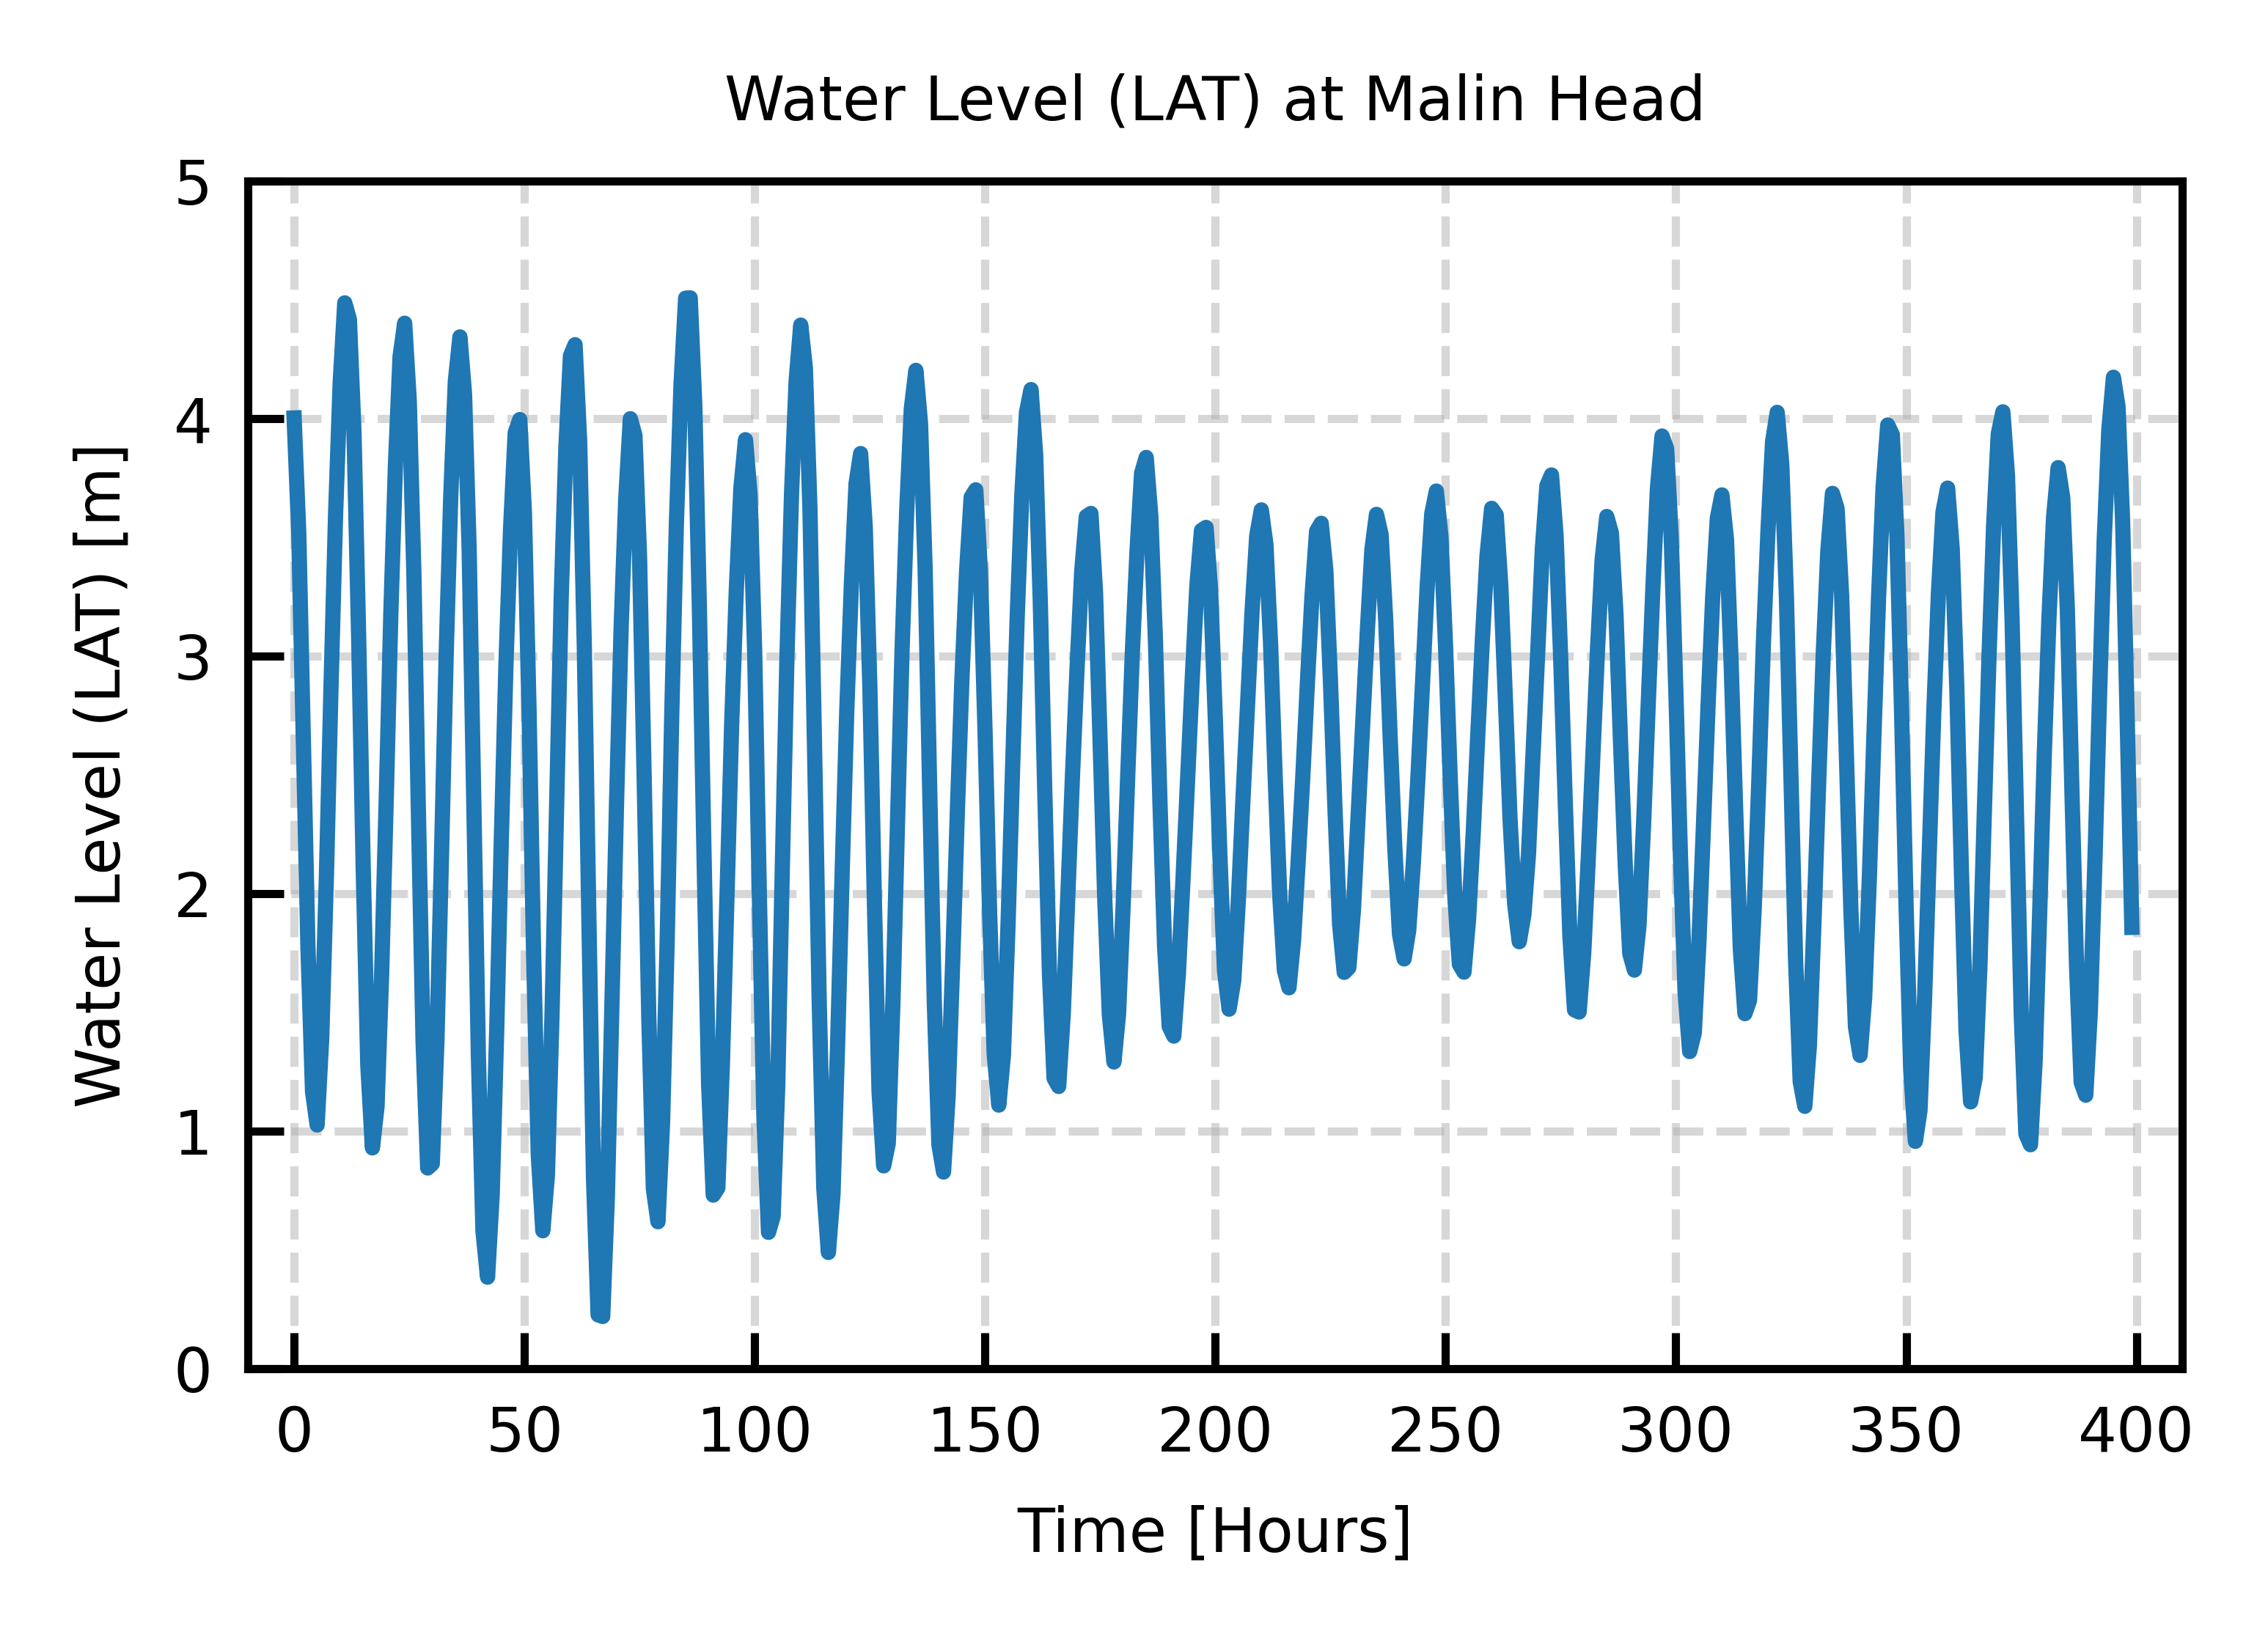

In [11]:
data = pd.read_csv("IrishNationalTideGaugeNetwork_070c_f250_eaf8.csv")
data = data["Water_Level_LAT"].drop(0).astype(float)
data = data.groupby(data.index // 12).mean()[:400]

plt.plot(data.index, data.values)
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.title('Water Level (LAT) at Malin Head')
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(-10, 410)
plt.ylim(0,5)
plt.show()

## Now let's get into the juicy details of physics

### Main idea

In contrast to our first approach, we now want to introduce the data not by parameterizing the beamsplitters, but by injecting the data via an ancilla mode. In this case the data corresponds to the probability of a photon being moved from the ancilla to one of the main modes.

### The procedure

#### 1. Setting up the circuit block: 
The circuit block consists of 
- a Mach-Zehnder interferometer with variable phase to inject one data point
- a beamsplitter cascade with fixed angles to spread the information
- a photon loss channel on each main mode for nonlinearity

#### 2. Measurement:
After each block of operations, we measure the main modes and save the resulting photon number expectation values per site. We then use the most likely state as the input for the next block of operations.

#### 3. Iteration:
With the resulting most likely state as the input for the next block. We repeat the circuit block for the next data point. This is done until all data points are injected.

### Introducing nonlinearity

##### To introduce nonlinearity in our model, we make use of two effects:

##### 1. Photon loss: 
After a certain number of operations we set photon loss channels on the main modes. The injected ancilla then also serves as a source of photons to compensate for the loss.

##### 2. Most probable state propagation: 
After each block of operations, we measure the main modes and use the most likely state as the input for the next block of operations.

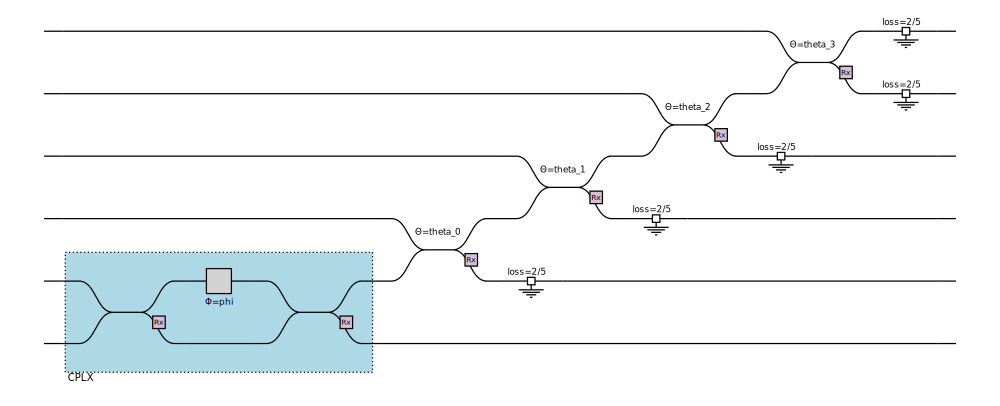

In [12]:
processor = pcvl.Processor("SLOS", 6)
    
# add a Mach Zehnder interferometer to inject the data
processor.add(5-1, pcvl.BS().add(0, pcvl.PS(phi=pcvl.P("phi"))).add(0, pcvl.BS()))

# add a beamsplitter cascade to ensure full connectivity
for j, index in enumerate([3, 2, 1, 0]):
    processor.add(index, pcvl.BS(pcvl.P(f"theta_{j}")))

# add loss channel to each mode
for k in range(5):
    processor.add(k, pcvl.LC(0.4))
pcvl.pdisplay(processor, recursive=True)

### Procedure

#### 1. Setting up the circuit block: 
The circuit block consists of 
- a Mach-Zehnder interferometer with variable phase to inject one data point
- a beamsplitter cascade with fixed angles
- a photon loss channel on each main mode

#### 2. Measurement:
After each block of operations, we measure the main modes and save the resulting photon number expectation values per site.

#### 3. Iteration:
We use the resulting most likely state as the input for the next block. We repeat the circuit block for the next data point. This is done until all data points are injected.

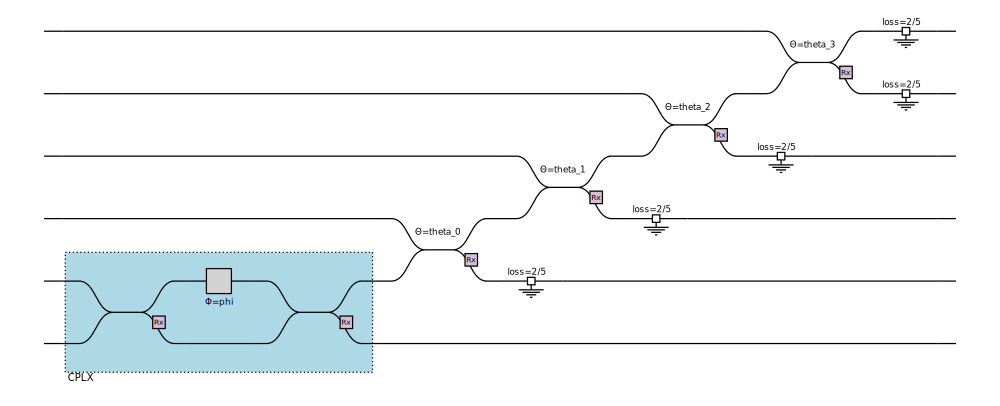

In [13]:
"""As before, we will connect the different modes by using a beamsplitter cascade"""

processor = pcvl.Processor("SLOS", 6)
    
# add a Mach Zehnder interferometer to inject the data
processor.add(5-1, pcvl.BS().add(0, pcvl.PS(phi=pcvl.P("phi"))).add(0, pcvl.BS()))

# add a beamsplitter cascade to ensure full connectivity
for j, index in enumerate([3, 2, 1, 0]):
    processor.add(index, pcvl.BS(pcvl.P(f"theta_{j}")))

# add loss channel to each mode
for k in range(5):
    processor.add(k, pcvl.LC(0.4))
pcvl.pdisplay(processor, recursive=True)

We fix the parameters of the processor and the ancilla.

In [14]:
def set_processor_parameters(processor, parameter_matrix):
    """
    Set the parameters of the processor to the values in the matrix.

    Args:
        processor (Processor): The processor to set the parameters for.
        parameter_matrix (np.ndarray): A matrix of size (t, num_parameters).

    Description:
        The parameter matrix is flattened to match the list of parameters.
        The parameters are set in the order they appear in the circuit.
    """
    flattened_params = parameter_matrix.flatten()
    params = list(processor.get_circuit_parameters().values())
    assert len(params) == len(
        flattened_params), f"Parameter length mismatch. Expected {len(params)} parameters, got {len(flattened_params)}."
    for param, value in zip(params, flattened_params):
        param.set_value(value)

### Set constants for our circuit

In [15]:
# Constants
N_MODES = 5
NUM_ANCILLAS = 1
INIT_PHOTON_NUMBER = 2
INIT_STATE = [0, 0, 0, 0, 0] + [INIT_PHOTON_NUMBER]
print(f"Initial state for new run {INIT_STATE}")
SCALE = 0.01
LOSS = 0.4
BS_INDEX = [3,2,1,0]
print("Beamsplitter arrangement", BS_INDEX)

Initial state for new run [0, 0, 0, 0, 0, 2]
Beamsplitter arrangement [3, 2, 1, 0]


After renormalizing the data, we use it 

Computing layer:   0%|          | 0/400 [00:00<?, ?it/s]

Computing layer: 100%|██████████| 400/400 [00:11<00:00, 35.31it/s] 

Expectation matrix shape (400, 5)
Final circuit


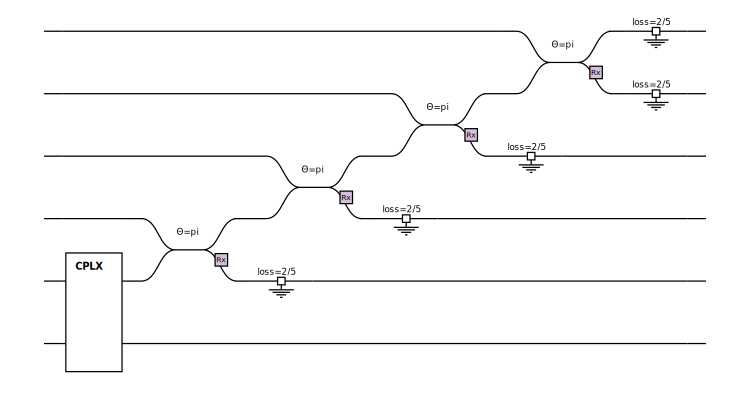

In [16]:
# Normalize data
data_renormalized = (data - min(data)) / (max(data) - min(data))
data_renormalized = data_renormalized.to_numpy()

# Initialize expectation matrix and set up parameter matrix
expectation_matrix = np.zeros((len(data_renormalized), N_MODES))
parameter_matrix = np.ones(len(BS_INDEX)) * np.pi 

# Main loop for circuit construction and simulation
for i in tqdm(range(len(data_renormalized)), desc="Computing layer"):
    processor = pcvl.Processor("SLOS", len(INIT_STATE))
    
    # add a Mach Zehnder interferometer to inject the data
    angle = data_renormalized[i]*2*np.pi
    processor.add(N_MODES-1, pcvl.BS().add(0, pcvl.PS(phi=angle)).add(0, pcvl.BS()))

    # add a beamsplitter cascade to ensure full connectivity
    for j, index in enumerate(BS_INDEX):
        processor.add(index, pcvl.BS(pcvl.P(f"theta_{j}")))
    # add loss channel to each mode
    for k in range(N_MODES):
        processor.add(k, pcvl.LC(LOSS))

    set_processor_parameters(processor, parameter_matrix)
    processor.with_input(pcvl.BasicState(INIT_STATE))

    # Simulate and sample the circuit
    sampler = pcvl.algorithm.Sampler(processor)
    prob_distribution = sampler.probs()['results']

    # Calculate expectations
    expectations = [0.0 for _ in range(N_MODES)]
    for state, probability in prob_distribution.items():
        for mode in range(N_MODES):
            expectations[mode] += state[mode] * probability
    expectation_matrix[i,:] = expectations

    # Update initial state for the next iteration
    INIT_STATE = list(max(prob_distribution, key=prob_distribution.get))[:N_MODES] + [INIT_PHOTON_NUMBER]

# Display the final circuit
print("Expectation matrix shape", expectation_matrix.shape)
print("Final circuit")
pcvl.pdisplay(processor, recursive=False)

#### Fitting the expectation values after each block of operations

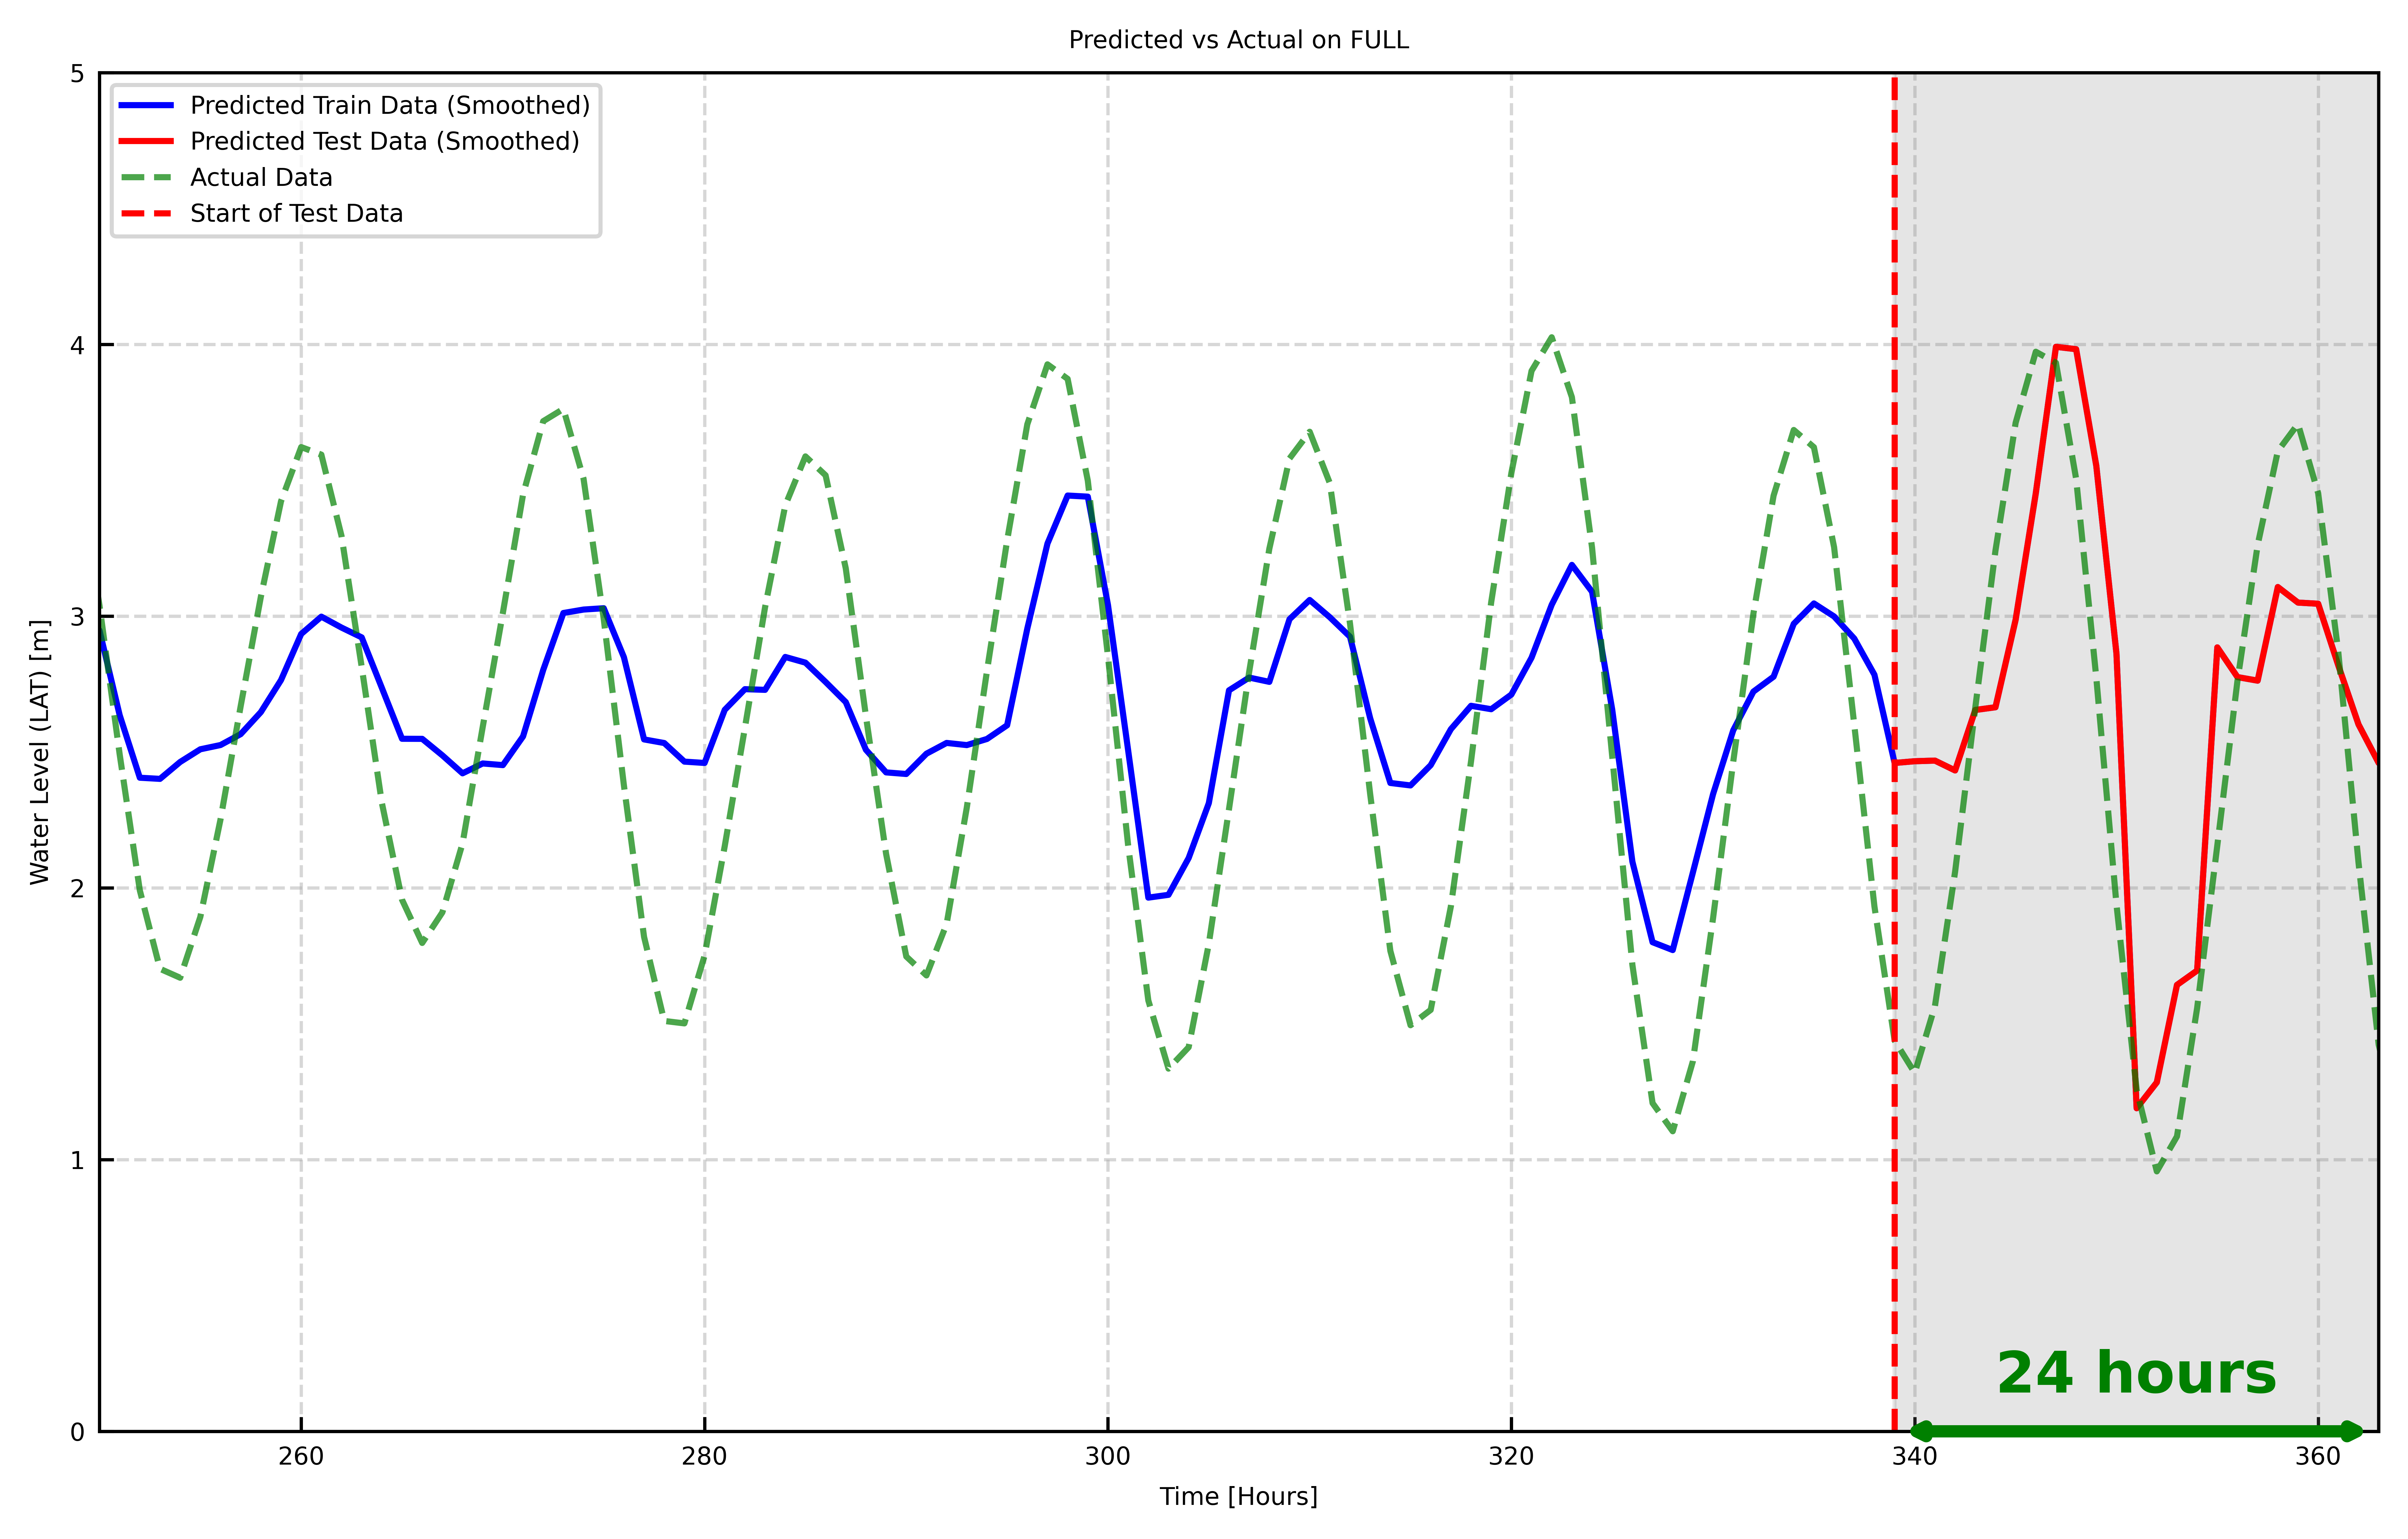

In [17]:
# Load the expectation values from the processor and data to predict
X = expectation_matrix[:-1]
y = data[1:]
y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, shuffle=False)

# Create polynomial features
poly = PolynomialFeatures(degree=10)
expectations_matrix_poly = poly.fit_transform(X_train)
reg_ridge = Ridge(alpha=4).fit(expectations_matrix_poly, y_train)
test_expectation_matrix_poly = poly.fit_transform(X_test)

# Make predictions using the polynomial model
predicted_data_poly = reg_ridge.predict(test_expectation_matrix_poly)

# Append predicted train quad and test quad
FULL_data_quad = np.append(reg_ridge.predict(expectations_matrix_poly), predicted_data_poly)

# Convert the FULL_data_quad array to a pandas Series for easy manipulation
FULL_data_quad_series = pd.Series(FULL_data_quad)

# Apply a moving average (rolling mean)
window_size = 4  # Adjust the window size as needed
FULL_data_quad_smoothed = FULL_data_quad_series.rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(10, 6))

# Plot the smoothed train predictions in blue and connect to test predictions
plt.plot(FULL_data_quad_smoothed, color='blue', label='Predicted Train Data (Smoothed)')

# Plot the smoothed test predictions in red from test_start_index
test_start_index = y_train.shape[0]
plt.plot(range(test_start_index, len(FULL_data_quad_smoothed)), FULL_data_quad_smoothed[test_start_index:], color='red', label='Predicted Test Data (Smoothed)')

# Plot the actual data in green dashed line
plt.plot(data, color='green', alpha=0.7, linestyle='--', label='Actual Data')

# Add a vertical line at test_start_index
plt.axvline(x=test_start_index, color='red', linestyle='--', label='Start of Test Data')

# Shade the test data region
x_max = 363  # Replace with your desired maximum x-value
plt.fill_betweenx(y=[-10, 10], x1=test_start_index, x2=x_max, color='grey', alpha=0.2)

# Set title and labels
plt.title(f'Predicted vs Actual on FULL')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')

# Set the x-axis limits to zoom in
x_min = 250  # Replace with your desired minimum x-value
plt.xlim(x_min, x_max)
y_min = 0
y_max = 5
plt.ylim(y_min, y_max)

# Add a horizontal double arrow
hours_length = x_max - test_start_index
plt.annotate(
    '',
    xy=(test_start_index, 0), xycoords='data',
    xytext=(test_start_index + hours_length, 0), textcoords='data',
    arrowprops=dict(arrowstyle='<->', color='green', linewidth=3)
)

# Increase the y-coordinate for text to add space between the text and the arrow
text_y_position = 0.1
plt.text(test_start_index + hours_length / 2, text_y_position, f'{hours_length} hours',
         verticalalignment='bottom', horizontalalignment='center',
         color='green', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.show()

### Discussion
This quantum linear optical reservoir model shows good predictive accuracy for the first 20 hours but has a less precise fit on the training data. This indicates a potential safeguard against overfitting. While the fit on the training set is not ideal, it may help the model generalize better to new data, balancing accuracy with the risk of overfitting.